In [1]:
from numpy import *
from matplotlib.pyplot import *
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from dynamo.tools.velocity import *
#from singleCellPotential import SparseVFC

In [2]:
rcParams.update({'font.size': 18})

# Clustering of Cell Populations using Unspliced Data (uu + ul)

In [3]:
data_uu_kin = []
data_su_kin = []
data_ul_kin = []
data_sl_kin = []
data_pr_kin = []
lT = array([])
T_CP = array([0, 5, 10, 40, 100, 200, 300, 400])
for i, t in enumerate(T_CP):
    data_uu_kin.append(pd.read_csv("./data/simulated_scSlamSeq/uu_treated_kin_T%d.csv"%(t), sep=','))
    data_su_kin.append(pd.read_csv("./data/simulated_scSlamSeq/su_treated_kin_T%d.csv"%(t), sep=','))
    data_ul_kin.append(pd.read_csv("./data/simulated_scSlamSeq/ul_treated_kin_T%d.csv"%(t), sep=','))
    data_sl_kin.append(pd.read_csv("./data/simulated_scSlamSeq/sl_treated_kin_T%d.csv"%(t), sep=','))
    data_pr_kin.append(pd.read_csv("./data/simulated_scSlamSeq/pr_treated_kin_T%d.csv"%(t), sep=','))
    lT = hstack((lT, [i]*len(data_uu_kin[i].values[0])))
Uu = hstack([data_uu_kin[i].values for i in range(len(T_CP))])
Su = hstack([data_su_kin[i].values for i in range(len(T_CP))])
Ul = hstack([data_ul_kin[i].values for i in range(len(T_CP))])
Sl = hstack([data_sl_kin[i].values for i in range(len(T_CP))])
U = Uu + Ul
S = Su + Sl
P = hstack([data_pr_kin[i].values for i in range(len(T_CP))])

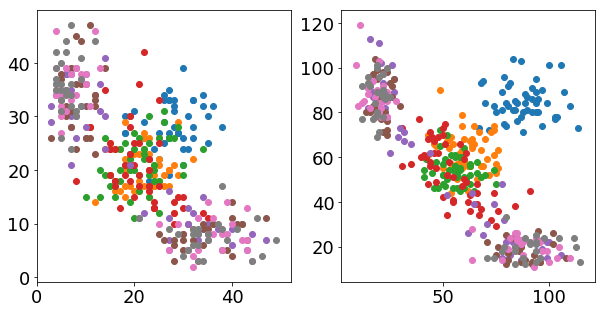

In [4]:
figure(figsize=(10,5))
ax1 = subplot(121)
ax2 = subplot(122)
for i in range(len(T_CP)):
    ax1.scatter(U[0][lT==i], U[1][lT==i])
    ax2.scatter(S[0][lT==i], S[1][lT==i])

In [5]:
# k-means clustering
nc = 4
kmeans = KMeans(n_clusters=nc, random_state=0).fit(U.T)
l = kmeans.labels_

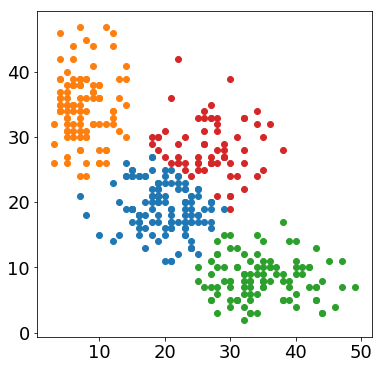

In [6]:
figure(figsize=(6,6))
for i in range(nc):
    scatter(U[0, l==i], U[1, l==i])

# Estimate Gamma and Beta using Degradation Data

In [7]:
data_uu_deg = []
data_su_deg = []
data_ul_deg = []
data_sl_deg = []
T = 400
Tl = array([0, 1, 2, 4, 8])
for i, t in enumerate(Tl):
    data_uu_deg.append(pd.read_csv("./data/simulated_scSlamSeq/uu_treated_deg_T%d_t%d.csv"%(T, t), sep=','))
    data_su_deg.append(pd.read_csv("./data/simulated_scSlamSeq/su_treated_deg_T%d_t%d.csv"%(T, t), sep=','))
    data_ul_deg.append(pd.read_csv("./data/simulated_scSlamSeq/ul_treated_deg_T%d_t%d.csv"%(T, t), sep=','))
    data_sl_deg.append(pd.read_csv("./data/simulated_scSlamSeq/sl_treated_deg_T%d_t%d.csv"%(T, t), sep=','))

## Beta and Gamma Estimation

In [8]:
w1 = array([data_ul_deg[i].values[0, :] for i in range(len(Tl))])
w2 = array([data_ul_deg[i].values[1, :] for i in range(len(Tl))])
w_deg = np.array([w1.T, w2.T])
l1 = array([data_sl_deg[i].values[0, :] for i in range(len(Tl))])
l2 = array([data_sl_deg[i].values[1, :] for i in range(len(Tl))])
l_deg = np.array([l1.T, l2.T])

Text(0, 0.5, 'l2')

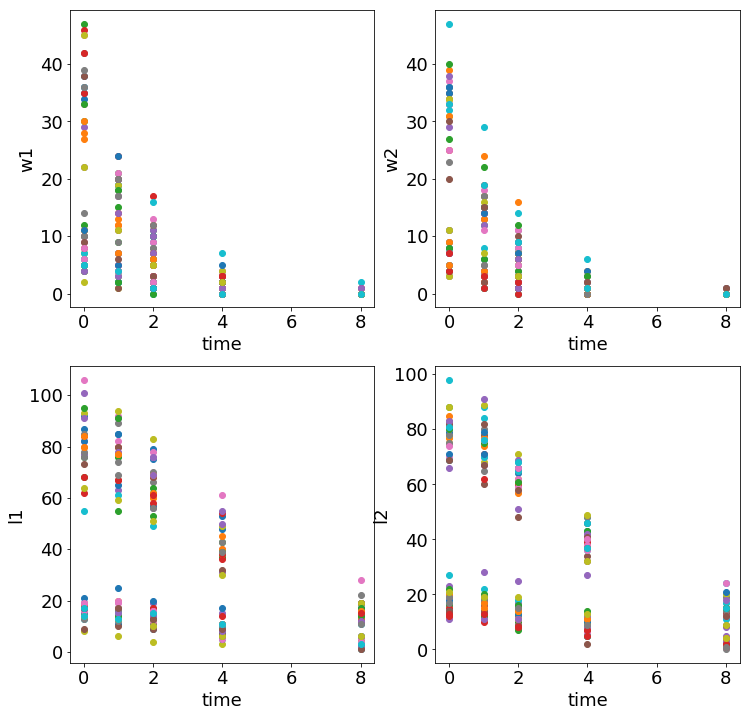

In [9]:
figure(figsize=(12, 12))
subplot(221)
plot(Tl, w1, 'o')
xlabel('time')
ylabel('w1')

subplot(222)
plot(Tl, w2, 'o')
xlabel('time')
ylabel('w2')

subplot(223)
plot(Tl, l1, 'o')
xlabel('time')
ylabel('l1')

subplot(224)
plot(Tl, l2, 'o')
xlabel('time')
ylabel('l2')

In [10]:
estm_deg = estimation(Ul=w_deg, Sl=l_deg, t=Tl, experiment_type='deg')
estm_deg.fit()
print ('beta1 = %.4f'%estm_deg.parameters['beta'][0])
print ('beta2 = %.4f'%estm_deg.parameters['beta'][1])
print ('gamma1 = %.4f'%estm_deg.parameters['gamma'][0])
print ('gamma2 = %.4f'%estm_deg.parameters['gamma'][1])

beta1 = 0.6739
beta2 = 0.7137
gamma1 = 0.2760
gamma2 = 0.2787


In [11]:
beta1, w1_0 = fit_beta_lsq(Tl, w1.T)
beta2, w2_0 = fit_beta_lsq(Tl, w2.T)
print ('beta1 = %.4f'%beta1)
print ('w1_0 = %.4f'%w1_0)
print ('beta2 = %.4f'%beta2)
print ('w2_0 = %.4f'%w2_0)

beta1 = 0.6739
w1_0 = 20.8171
beta2 = 0.7137
w2_0 = 20.2131


In [12]:
gamma1, l1_0 = fit_gamma_lsq(Tl, l1.T, beta1, w1_0)
gamma2, l2_0 = fit_gamma_lsq(Tl, l2.T, beta2, w2_0)
print ('gamma1 = %.4f'%gamma1)
print ('l1_0 = %.4f'%l1_0)
print ('gamma2 = %.4f'%gamma2)
print ('l2_0 = %.4f'%l2_0)

gamma1 = 0.2760
l1_0 = 46.9884
gamma2 = 0.2787
l2_0 = 49.1305


In [13]:
VS = velocity(estimation=estm_deg).vel_s(U, S)

In [34]:
VS_true = velocity(beta=0.5/0.7*np.ones(2), gamma=0.2/0.7*np.ones(2)).vel_s(U, S)

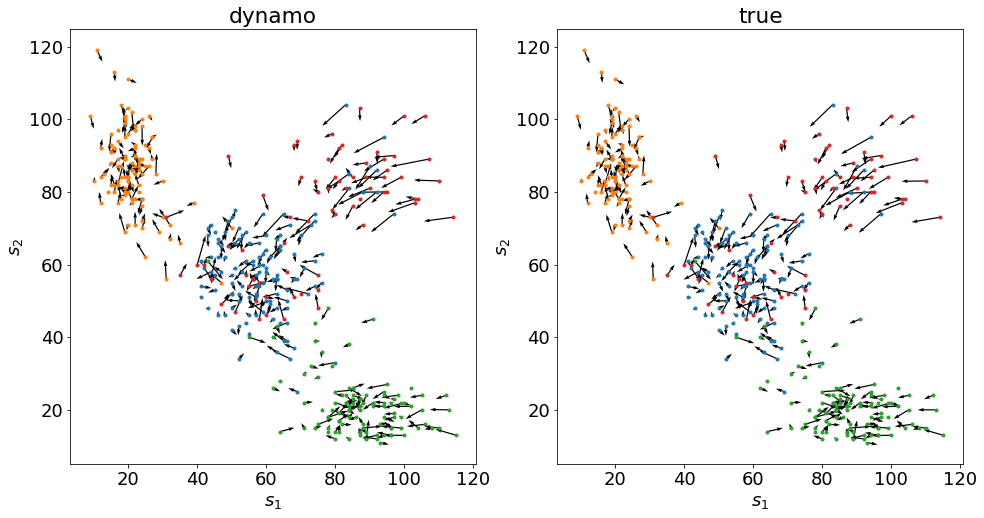

In [38]:
# velocity plot
figure(figsize=(16,8))
subplot(121)
quiver(S[0], S[1], VS[0], VS[1])
xlabel(r'$s_1$')
ylabel(r'$s_2$')
title('dynamo')

for i in range(nc):
    scatter(S[0][l==i], S[1][l==i], marker='.' )
    
subplot(122)
quiver(S[0], S[1], VS_true[0], VS_true[1])
xlabel(r'$s_1$')
ylabel(r'$s_2$')
title('true')

for i in range(nc):
    scatter(S[0][l==i], S[1][l==i], marker='.' )

# Estimate Gamma/Beta using Steady State Assumption

In [15]:
estm_deg_ss = estimation(U=Uu, S=Su, Ul=Ul, Sl=Sl, t=Tl, experiment_type='deg', assumption_mRNA='ss')
estm_deg_ss.fit(intercept=False, perc_left=5, perc_right=5)
print ('beta1 = %.4f'%estm_deg_ss.parameters['beta'][0])
print ('beta2 = %.4f'%estm_deg_ss.parameters['beta'][1])
print ('gamma1 = %.4f'%estm_deg_ss.parameters['gamma'][0])
print ('gamma2 = %.4f'%estm_deg_ss.parameters['gamma'][1])

beta1 = 1.0000
beta2 = 1.0000
gamma1 = 0.3733
gamma2 = 0.3733


Text(0, 0.5, 'U2')

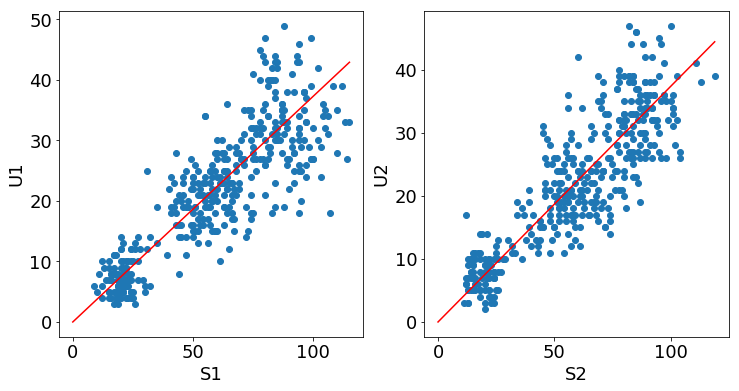

In [16]:
figure(figsize=(12,6))
subplot(121)
scatter(S[0], U[0])
plot([0, np.max(S[0])], [0, estm_deg_ss.parameters['gamma'][0]*np.max(S[0])], 'r')
xlabel('S1')
ylabel('U1')

subplot(122)
scatter(S[1], U[1])
plot([0, np.max(S[1])], [0, estm_deg_ss.parameters['gamma'][1]*np.max(S[1])], 'r')
xlabel('S2')
ylabel('U2')

In [17]:
VS_ss = velocity(estimation=estm_deg_ss).vel_s(U, S)

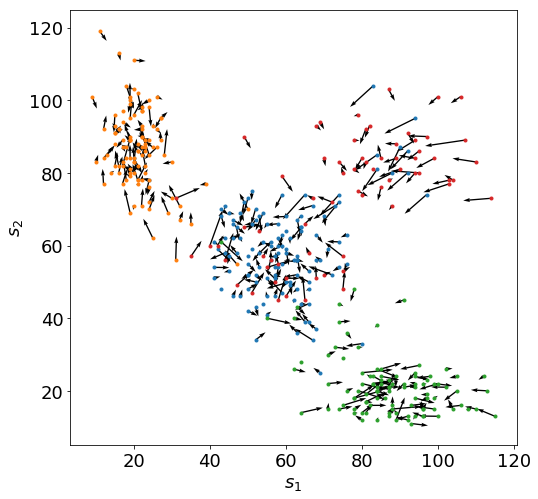

In [18]:
# velocity plot
figure(figsize=(8,8))
quiver(S[0], S[1], VS_ss[0], VS_ss[1])
xlabel(r'$s_1$')
ylabel(r'$s_2$')

for i in range(nc):
    scatter(S[0][l==i], S[1][l==i], marker='.' )

# Estimate Alpha using Clustered Kinetics Data

In [19]:
clusters = [[] for i in range(nc)]
for i in range(len(l)):
    clusters[l[i]].append(i) 

In [20]:
t_lab = 1.0
estm_kmeans = estimation(Ul=Ul, t=t_lab, experiment_type='one_shot')
estm_kmeans.parameters['beta'] = estm_deg.parameters['beta']
estm_kmeans.fit(clusters=clusters)
print(estm_kmeans.parameters['alpha'])

[[13.4178449   5.64342473 24.88942851 17.10053318]
 [13.54533404 24.92542167  5.71921361 16.78733203]]


In [21]:
V_km = np.zeros(U.shape)
uc = kmeans.cluster_centers_
sig = 5
for i in range(U.shape[1]):
    x = array([U[0][i], U[1][i]])
    w = array([exp(-(linalg.norm(x - uc[k]))**2/(2*sig**2)) for k in range(nc)])
    w = w/sum(w)
    alpha1 = w.dot(estm_kmeans.parameters['alpha'][0])
    alpha2 = w.dot(estm_kmeans.parameters['alpha'][1])
    V_km[0][i] = alpha1 - beta1 * U[0][i]
    V_km[1][i] = alpha2 - beta2 * U[1][i]

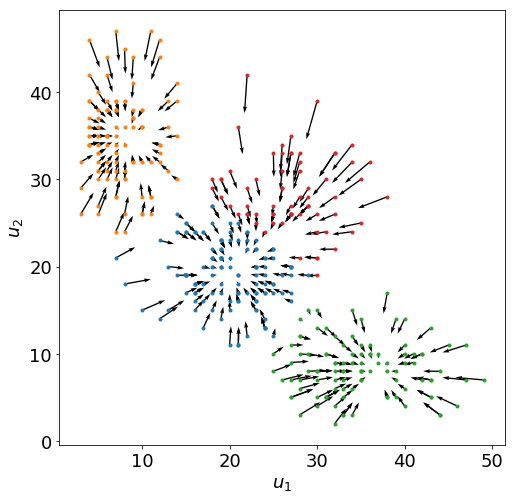

In [22]:
# velocity plot
figure(figsize=(8,8))
quiver(U[0], U[1], V_km[0], V_km[1])
xlabel(r'$u_1$')
ylabel(r'$u_2$')

for i in range(nc):
    scatter(U[0][l==i], U[1][l==i], marker='.' )

# Estimate Alpha using Nearest Neighbors

In [23]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(U.T)
distances, indices = nbrs.kneighbors(U.T)

In [24]:
estm_knn = estimation(Ul=Ul, t=t_lab, experiment_type='one_shot')
estm_knn.parameters['beta'] = estm_deg.parameters['beta']
estm_knn.fit(clusters=indices)

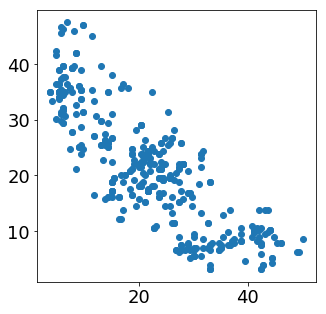

In [25]:
figure(figsize=(5,5))
scatter(estm_knn.parameters['alpha'][0]/estm_knn.parameters['beta'][0], estm_knn.parameters['alpha'][1]/estm_knn.parameters['beta'][1])

In [26]:
V_knn = velocity(estimation=estm_knn).vel_u(U)

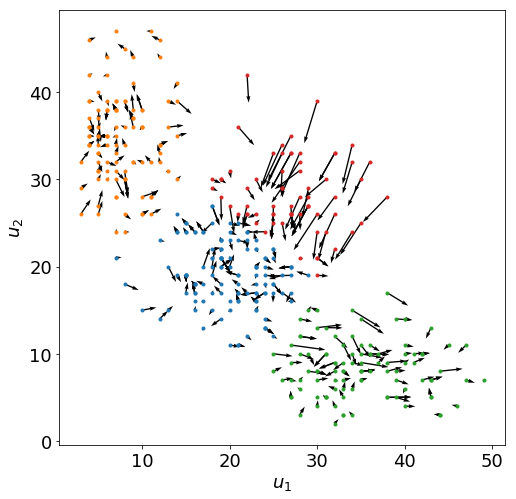

In [27]:
# velocity plot
figure(figsize=(8,8))
quiver(U[0], U[1], V_knn[0], V_knn[1])
xlabel(r'$u_1$')
ylabel(r'$u_2$')

for i in range(nc):
    scatter(U[0][l==i], U[1][l==i], marker='.' )

# Estimate Delta/Eta for Protein Data with Steady State Assumption

In [28]:
estm_pr = estimation(P=P, S=S)
estm_pr.fit(intercept=False, perc_left=10, perc_right=10)
print ('eta1 = %.4f'%estm_pr.parameters['eta'][0])
print ('eta2 = %.4f'%estm_pr.parameters['eta'][1])
print ('delta1 = %.4f'%estm_pr.parameters['delta'][0])
print ('delta2 = %.4f'%estm_pr.parameters['delta'][1])

eta1 = 1.0000
eta2 = 1.0000
delta1 = 0.1007
delta2 = 0.0987


Text(0, 0.5, '$s_2$')

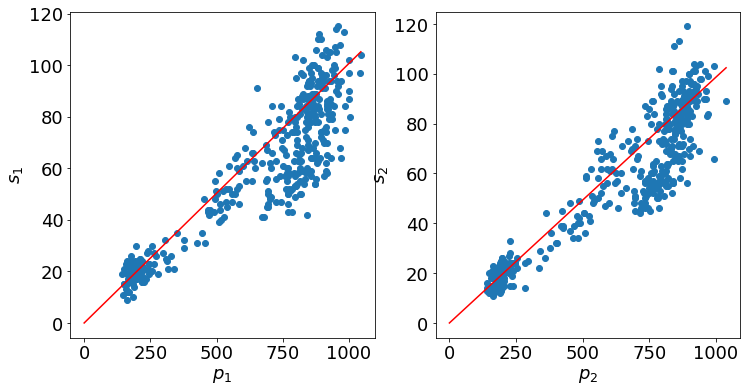

In [29]:
figure(figsize=(12,6))
subplot(121)
scatter(P[0], S[0])
plot([0, np.max(P[0])], [0, estm_pr.parameters['delta'][0]*np.max(P[0])], 'r')
xlabel(r'$p_1$')
ylabel(r'$s_1$')

subplot(122)
scatter(P[1], S[1])
plot([0, np.max(P[1])], [0, estm_pr.parameters['delta'][1]*np.max(P[1])], 'r')
xlabel(r'$p_2$')
ylabel(r'$s_2$')

In [30]:
VP = np.zeros(P.shape)
for i in range(P.shape[1]):
    VP[0][i] = S[0][i] - estm_pr.parameters['delta'][0] * P[0][i]
    VP[1][i] = S[1][i] - estm_pr.parameters['delta'][1] * P[1][i]

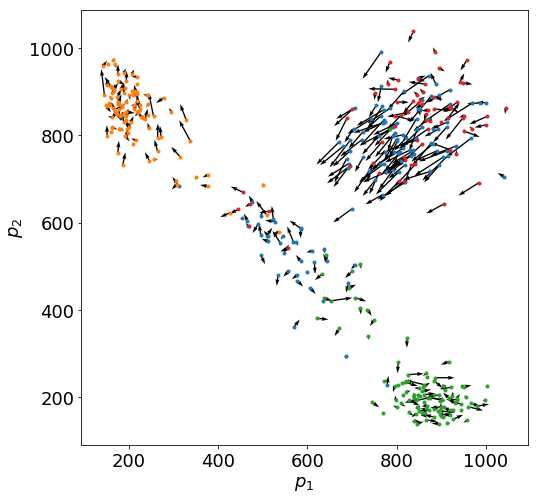

In [31]:
# velocity plot
figure(figsize=(8,8))
quiver(P[0], P[1], VP[0], VP[1])
xlabel(r'$p_1$')
ylabel(r'$p_2$')

for i in range(nc):
    scatter(P[0][l==i], P[1][l==i], marker='.' )

# Vector Field Reconstruction

In [32]:
U; V_knn;  # unspliced mRNA and velocity
S; VS; # spliced mRNA and velocity
P; VP; # spliced mRNA and velocity